# Working with zones

Trove's zones are important in constructing API requests and interpreting the results. So let's explore them a bit.

You're probably already familiar with Trove's zones from the web site.

There are 10 zones in Trove (11 if you regard the newspapers and gazettes as separate):

* Digitised newspapers and gazettes 
* Journals, articles and data sets
* Books
* Pictures, photos and objects
* Music, sound and video
* Maps
* Diaries, letters and archives
* People and organisations
* Archived websites
* Lists

However, data from the 'People and organisations' and 'Archives websites' zones are not available through the API. Well, sort of not...

Let's see what the API itself can tell us about the zones.

## Setting things up

We'll start by importing the modules we're going to need later on.

In [1]:
# Let's import the modules we need 
import requests
import os

# Altair helps us make pretty charts
import altair as alt

# Pandas helps us analyse tabular data
import pandas as pd

# This lets Altair draw charts in cells
alt.renderers.enable('notebook')

os.makedirs('data', exist_ok=True)

As usual we're going to need a Trove API key.

In [18]:
# This creates a variable called 'api_key', paste your key between the quotes
api_key = ''

# This displays a message with your key
print('Your API key is: {}'.format(api_key))

Your API key is: 


We'll also set the base url for our API requests.

In [3]:
# Create a variable called 'api_search_url' and give it a value
api_search_url = 'https://api.trove.nla.gov.au/result'

## Give us everything!

This time we're going to ask for **everything** from **all** the zones. (Don't worry, you won't break anything, Trove will only give us the first 20 results in each zone.)

To do this, we'll set the `q` parameter to be an empty string (quotes around a space), and the `zone` parameter to 'all'.

In [4]:
# This creates a dictionary called 'params' and sets values for the API's parameters
params = {
    'q': ' ', # A space to search for everything
    'zone': 'all', # All zones thanks!
    'key': api_key,
    'encoding': 'json'
}

We can now send our request off to the Trove API. Because we're not applying any limits to our query, the API can take a little longer than normal to respond. Just wait for the asterix in the square brackets to turn into a number, and then move on.

In [5]:
# This sends our request to the Trove API and stores the result in a variable called 'response'
response = requests.get(api_search_url, params=params)

# This shows us the url that's sent to the API
print(response.url) # This shows us the url that's sent to the API

# This checks the status code of the response to make sure there were no errors
if response.status_code == requests.codes.ok:
    print('All ok')
elif response.status_code == 403:
    print('There was an authentication error. Did you paste your API above?')
else:
    print('There was a problem. Error code: {}'.format(response.status_code))
    print('Try running this cell again.')

https://api.trove.nla.gov.au/result?q=+&zone=all&key=6pi5hht0d2umqcro&encoding=json
All ok


As before we'll get the JSON results data from the API response.

In [6]:
# Get the Trove API's JSON results and make them available as a Python variable called 'data'
data = response.json()

If you'd like to have a look at the raw data, run the next cell.

In [7]:
# Let's prettify the raw JSON data and then display it.

# We're using the Pygments library to add some colour to the output, so we need to import it
import json
from pygments import highlight, lexers, formatters

# This uses Python's JSON module to output the results as nicely indented text
formatted_data = json.dumps(data, indent=2)

# This colours the text
highlighted_data = highlight(formatted_data, lexers.JsonLexer(), formatters.TerminalFormatter())

# And now display the results
print(highlighted_data)

{
  "response": {
    "query": "",
    "zone": [
      {
        "name": "list",
        "records": {
          "s": "0",
          "n": "20",
          "total": "81750",
          "next": "/result?q=+&encoding=json&zone=list&s=20",
          "list": [
            {
              "id": "29522",
              "url": "/list/29522",
              "troveUrl": "http://trove.nla.gov.au/list?id=29522",
              "title": "Rockhampton Cordia lmanufacturer's",
              "creator": "public:bozzo2",
              "description": "in the 6th Column A.J Kempt and Co",
              "listItemCount": 4,
              "relevance": {
                "score": "1.0",
                "value": "very relevant"
              }
            },
            {
              "id": "38068",
              "url": "/list/38068",
              "troveUrl": "http://trove.nla.gov.au/list?id=38068",
              "title": "lavis",
              "creator": "public:yetta",
              "listItemCount": 2,
           

## Looking into the zones

Now we've got data from all of Trove's zone – let's see what it looks like!

The next code cell loops through each zone in the results and extracts the total number of results. Because we didn't apply any limits to our query, this will tell us how many items are currently in each zone.

In [8]:
# Create empty lists to store 'zones' and 'totals'
zones = []
totals = []

# Loop through the zones in the API results
for zone in data['response']['zone']:

    # Add the name and total values to the relevant list
    zones.append(zone['name'])
    totals.append(int(zone['records']['total']))
        
# Save the results as a dictionary
zone_totals = {'zones': zones, 'totals': totals}

We're now going to convert the results into a Pandas dataframe. Pandas has lots of useful options for working with and displaying tabular data.

In [9]:
# Create a Pandas dataframe to work with the results
df = pd.DataFrame(zone_totals)

# Sort by zone name
df = df.sort_values(by='zones')

# Display as a table (formatting the numbers with comma separators for readability)
df[['zones', 'totals']].style.format({'totals': '{:,}'})

,zones,totals
2,article,"12,656,951"
3,book,"19,607,113"
6,collection,"457,334"
0,list,"81,750"
4,map,"445,227"
7,music,"2,632,339"
8,newspaper,"225,335,598"
1,people,"1,186,095"
5,picture,"4,075,878"


In [10]:
# We can even use Pandas to display the results table with a simple bar chart
df[['zones', 'totals']].style.format({'totals': '{:,}'}).bar(subset=['totals'], color='#d65f5f')

,zones,totals
2,article,"12,656,951"
3,book,"19,607,113"
6,collection,"457,334"
0,list,"81,750"
4,map,"445,227"
7,music,"2,632,339"
8,newspaper,"225,335,598"
1,people,"1,186,095"
5,picture,"4,075,878"


That's pretty cool, but let's take things one step further and use Plotly to create a pretty interactive bar chart. As you can see from the cell below, Plotly is very easy to use.

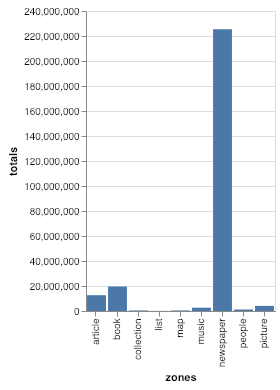

In [13]:
alt.Chart(df).mark_bar().encode(
    x='zones:N',
    y='totals:Q'
)

Ok, let's stop making pictures and look at what the results tell us. It's probably no surprise that there are more digitised newspaper articles that anything else.

Most of the zone names are familiar, though it might not be immediately obvious that the 'article' zone corresponds to the 'Journals, articles and data sets' zone in the web interface.

However, you might be wondering about 'collection'. It's not 'Lists' as there's already a 'list' zone in the results. It turns out that the 'collection' zone corresponds to the 'Diaries, letters and archives' zone in the web interface. I suppose it sort of makes sense.

You might also have noticed that although I said that the API didn't include results for the 'People and organisations' zone, there is a result in the data above for 'people'. What's going on?

Basically full support for the 'People and organisations' zone was never completed. Don't believe me? Let's have a look at the results.

First we'll extract the results for the 'people' zone from the API data.

In [14]:
# Create an empty list to store the results
people_results = []

# Loop through the zone results
for zone in data['response']['zone']:
    
    # When we find the people zone save the records data to 'people_results'
    if zone['name'] == 'people':
        people_results = zone['records']['people']        

Once again, we'll convert the results into a dataframe and display the first 5 rows as a table

In [15]:
# Create a datafram from 'people_results'
people_df = pd.DataFrame(people_results)

# Display the first 5 results as a table
people_df[:5]

,id,troveUrl,url
0,820577,http://trove.nla.gov.au/people/820577,/people/820577
1,475863,http://trove.nla.gov.au/people/475863,/people/475863
2,853539,http://trove.nla.gov.au/people/853539,/people/853539
3,853544,http://trove.nla.gov.au/people/853544,/people/853544
4,486843,http://trove.nla.gov.au/people/486843,/people/486843


You'll notice that there's not a lot of useful data – just identifiers and urls for the Trove web interface. If you try to use the identifier to get more information from the API you'll be out of luck – it returns a '404: Not Found' error.

As I said, full support for the 'People and organisations' zone was never completed. Hopefully it will be added in a future release.

## More zone peculiarities

There's another couple of peculiarities that you need to be aware of. The first is really more of an annoyance than a peculiarity. As you might have noticed above, to find the results for the 'people'zone I had to loop through all the zones until I found the one with the name 'people'. We can't just say, 'give me the people results!'. Of course, this is only an issue if you've asked for results from more than one zone. If you set the 'zone' parameter to a single zone – like 'newspaper' – the newspaper data would be the first (and only) set of results. You could find them at  `data['response']['zone'][0]`.

You might also have noticed that the individual records from the 'people' zone were found at `zone['records']['people']`. What's wrong with that? Well, it means that different zones use different keys to identify their records. So you have to know in advance what the key is in order to get the records data. Again, if you're only working with one zone it's not too hard. But if you're working across multiple zones, it's a bit of a pain.

At least we can use the data we've already gathered to create a mapping of zones to keys.

In [16]:
# Create an empty list to store the results
zone_keys = []

# Loop through the zones
for zone in data['response']['zone']:
    
    # Get the name of the zone
    zone_name = zone['name']
    
    # Loop through the keys
    for key in zone['records'].keys():
        
        # Check the key against the keys that are always there
        if key not in ['s', 'n', 'total', 'next']:
            # If it's not one of the standard keys save it
            records_key = key
    # Append the zone name and records key to our list
    zone_keys.append({'zone_name': zone_name, 'records_key': records_key})
    
# Convert the results to a dataframe
keys_df = pd.DataFrame(zone_keys)

# Sort and display the results
keys_df = keys_df.sort_values(by='records_key')
keys_df[['zone_name', 'records_key']]
            

,zone_name,records_key
8,newspaper,article
0,list,list
1,people,people
2,article,work
3,book,work
4,map,work
5,picture,work
6,collection,work
7,music,work


As you can see, the 'newspaper', 'list', and 'people' zones all have specific keys. Every other zone uses 'work'.

We'll learn more about how to use these keys in the [Getting records](4. Getting records.ipynb) section.

## Finally...

If you want to save the zones data, just run the cell below to create a CSV-formatted file.

In [17]:
# Save the zones data to a CSV file you can download
df.to_csv('data/trove_zones.csv', index=False)

Once you've created it, you can download this file from the workbench's [data directory](data).